In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
import pyaudio

In [3]:
# Courant number
cn = 0.9 / np.sqrt(2.0)
# Pi
pi = 3.14
# Constants
alpha = (0.0, 0.0)  # sound attenuation coefficient
alphap = (0.0, 0.0)  # sound attenuation coefficient
# Default number of media
nm = 2

In [4]:
class FdtdVar:
    def __init__(self, rs, cs):
        self.r = np.int(rs)
        self.c = np.int(cs)
        self.freq = freq
        temp = (self.r, self.c + 1)
        self.vx = np.zeros(temp)
        self.mvx = np.zeros(temp, dtype=np.int8)
        temp = (self.r + 1, self.c)
        self.vy = np.zeros(temp)
        self.mvy = np.zeros(temp, dtype=np.int8)
        temp = (self.r, self.c)
        self.pr = np.zeros(temp)
        self.gaussamp = np.zeros(temp)
        self.mpr = np.zeros(temp, dtype=np.int8)
        self.dx = wavelmin/10.0
        self.dt = cn * self.dx / np.amax(c0)
        self.ca = np.ones(nm)
        self.cb = np.ones(nm)
        self.da = np.ones(nm)
        self.db = np.ones(nm)
        for i in range(0, nm, 1):
            # self.ca[i] = ((2 * c0[i]**2 * rho[i] - alpha[i] * self.dt)
            #               / (2 * c0[i]**2 * rho[i] + alpha[i] * self.dt))
            self.cb[i] = c0[i] ** 2 * rho[i] * self.dt / self.dx
            # self.da[i] = ((2 * rho[i] - alphap[i] * self.dt)
            #               / (2 * rho[i] + alphap[i] * self.dt))
            self.db[i] = self.dt / (rho[i] * self.dx)
        self.da[1] = 0
        temp = (self.r, 2, 2)
        self.vxl = np.zeros(temp)
        self.vxr = np.zeros(temp)
        temp = (self.c, 2, 2)
        self.vyb = np.zeros(temp)
        self.vyt = np.zeros(temp)
        print("dx [m] = ", self.dx)
        print("dt [s] = ", self.dt)
        print("")
        rtemp = np.arange(0, self.r, 1)
        ctemp = np.arange(0, self.c, 1)
        rm, cm = np.meshgrid(rtemp, ctemp)
        rc = np.int(self.r / 2)
        cc = np.int(self.c / 2)
        if stype == "point":
            fwhmc = 2
            fwhmr = fwhmc
            self.gaussamp = np.exp(-((rm - rc) ** 2 / (2 * fwhmr ** 2) + (cm - cc) ** 2 / (2 * fwhmc ** 2))).T
        elif stype == "line":
            fwhmc = 2
            fwhmr = 16
            self.gaussamp = np.exp(-((rm - rc) ** 2 / (2 * fwhmr ** 2) + (cm - cc) ** 2 / (2 * fwhmc ** 2))).T

    def source(self, nt):
        rm = self.r
        cm = self.c
        # prs = self.dx * np.sin(2 * pi * self.freq * nt * self.dt) / self.cb[0]
        if sflag == "a":
            if nt < np.alen(asource):
                prs = self.dx * asource[nt] / self.cb[0]
            else:
                prs = 0
        else:
            prs = self.dx * np.sin(2 * pi * self.freq * nt * self.dt) / self.cb[0]

        # Update pressure with source
        self.pr[1:rm - 1, 1:cm - 1] = (self.pr[1:rm - 1, 1:cm - 1]
                                       - self.cb[self.mpr[1:rm - 1, 1:cm - 1]] * prs
                                       * self.gaussamp[1:rm - 1, 1:cm - 1] / self.dx)

    def fdtd_update(self):
        ri = self.r
        ci = self.c

        self.pr[0:ri, 0:ci] = (self.ca[self.mpr[0:ri, 0:ci]] * self.pr[0:ri, 0:ci]
                               - self.cb[self.mpr[0:ri, 0:ci]]
                               * ((self.vx[0:ri, 1:ci + 1] - self.vx[0:ri, 0:ci])
                                  + (self.vy[1:ri + 1, 0:ci] - self.vy[0:ri, 0:ci])))
        self.vx[0:ri, 1:ci] = (self.da[self.mvx[0:ri, 1:ci]] * self.vx[0:ri, 1:ci]
                               - self.db[self.mvx[0:ri, 1:ci]] * (self.pr[0:ri, 1:ci] - self.pr[0:ri, 0:ci - 1]))
        self.vy[1:ri, 0:ci] = (self.da[self.mvy[1:ri, 0:ci]] * self.vy[1:ri, 0:ci]
                               - self.db[self.mvy[1:ri, 0:ci]] * (self.pr[1:ri, 0:ci] - self.pr[0:ri - 1, 0:ci]))

    def boundary(self):
        ri = self.r
        ci = self.c
        c1 = (c0[0] * self.dt - self.dx) / (c0[0] * self.dt + self.dx)
        c2 = 2 * self.dx / (c0[0] * self.dt + self.dx)
        c3 = (c0[0] * self.dt) ** 2 / (2 * self.dx * (c0[0] * self.dt + self.dx))
        # Left and right boundaries
        self.vx[1:ri - 1, 0] = (-self.vxl[1:ri - 1, 1, 1]
                                + c1 * (self.vx[1:ri - 1, 1] + self.vxl[1:ri - 1, 0, 1])
                                + c2 * (self.vxl[1:ri - 1, 0, 0] + self.vxl[1:ri - 1, 1, 0])
                                + c3 * (self.vxl[2:ri, 0, 0] - 2 * self.vxl[1:ri - 1, 0, 0]
                                        + self.vxl[0:ri - 2, 0, 0] + self.vxl[2:ri, 1, 0]
                                        - 2 * self.vxl[1:ri - 1, 1, 0] + self.vxl[0:ri - 2, 1, 0]))
        self.vx[1:ri - 1, ci] = (-self.vxr[1:ri - 1, 1, 1]
                                 + c1 * (self.vx[1:ri - 1, ci - 1] + self.vxr[1:ri - 1, 0, 1])
                                 + c2 * (self.vxr[1:ri - 1, 0, 0] + self.vxr[1:ri - 1, 1, 0])
                                 + c3 * (self.vxr[2:ri, 0, 0] - 2 * self.vxr[1:ri - 1, 0, 0]
                                         + self.vxr[0:ri - 2, 0, 0] + self.vxr[2:ri, 1, 0]
                                         - 2 * self.vxr[1:ri - 1, 1, 0] + self.vxr[0:ri - 2, 1, 0]))

        # Bottom and top boundaries
        self.vy[0, 1:ci - 1] = (-self.vyb[1:ci - 1, 1, 1]
                                + c1 * (self.vy[1, 1:ci - 1] + self.vyb[1:ci - 1, 0, 1])
                                + c2 * (self.vyb[1:ci - 1, 0, 0] + self.vyb[1:ci - 1, 1, 0])
                                + c3 * (self.vyb[2:ci, 0, 0] - 2 * self.vyb[1:ci - 1, 0, 0]
                                        + self.vyb[0:ci - 2, 0, 0] + self.vyb[2:ci, 1, 0]
                                        - 2 * self.vyb[1:ci - 1, 1, 0] + self.vyb[0:ci - 2, 1, 0]))
        self.vy[ri, 1:ci - 1] = (-self.vyt[1:ci - 1, 1, 1]
                                 + c1 * (self.vy[ri - 1, 1:ci - 1] + self.vyt[1:ci - 1, 0, 1])
                                 + c2 * (self.vyt[1:ci - 1, 0, 0] + self.vyt[1:ci - 1, 1, 0])
                                 + c3 * (self.vyt[2:ci, 0, 0] - 2 * self.vyt[1:ci - 1, 0, 0]
                                         + self.vyt[0:ci - 2, 0, 0] + self.vyt[2:ci, 1, 0]
                                         - 2 * self.vyt[1:ci - 1, 1, 0] + self.vyt[0:ci - 2, 1, 0]))
        # Corners
        self.vx[0, 0] = self.vxl[1, 1, 1]
        self.vx[ri - 1, 0] = self.vxl[ri - 2, 1, 1]
        self.vx[0, ci] = self.vxr[1, 1, 1]
        self.vx[ri - 1, ci] = self.vxr[ri - 2, 1, 1]
        self.vy[0, 0] = self.vyb[1, 1, 1]
        self.vy[0, ci - 1] = self.vyb[ci - 2, 1, 1]
        self.vy[ri, 0] = self.vyt[1, 1, 1]
        self.vy[ri, ci - 1] = self.vyt[ci - 2, 1, 1]

        # Store boundary values
        for i in range(0, 2, 1):
            self.vxl[0:ri, i, 1] = self.vxl[0:ri, i, 0]
            self.vxl[0:ri, i, 0] = self.vx[0:ri, i]
            self.vxr[0:ri, i, 1] = self.vxr[0:ri, i, 0]
            self.vxr[0:ri, i, 0] = self.vx[0:ri, ci - i]
            self.vyb[0:ci, i, 1] = self.vyb[0:ci, i, 0]
            self.vyb[0:ci, i, 0] = self.vy[i, 0:ci]
            self.vyt[0:ci, i, 1] = self.vyt[0:ci, i, 0]
            self.vyt[0:ci, i, 0] = self.vy[ri - i, 0:ci]

    def update_domain(self):
        if mflag == "y":
            cm = self.c
            rm = self.r
            c1 = np.int(cm/2) + np.int(cm/8)
            c2 = c1 + np.int(cm/8)
            self.mvx.fill(0)
            self.mvy.fill(0)
            self.mpr.fill(0)
            self.mvx[40:rm - 40, c1:c2] = 2
            self.mvy[40:rm - 40, c1:c2] = 2
            self.mpr[40:rm - 40, c1:c2] = 2
        elif mflag == "n":
            self.mvx.fill(0)
            self.mvy.fill(0)
            self.mpr.fill(0)


def test():
    t1 = FdtdVar(480, 640)
    for nt in range(1, 500, 1):
        t1.fdtd_update()
        t1.source(nt)
        t1.boundary()
        cv2.imshow("frame", t1.pr)
        # if cv2.waitKey(1) & 0xFF == ord("q"):
        #     break
        plt.pcolormesh(t1.pr, cmap="gray_r", vmin=-1, vmax=1)
        plt.axis("image")
        plt.colorbar()
        plt.pause(0.1)
        plt.clf()
    plt.show()


In [5]:
# Ask for user input
dflag = input("Enter 'd' to run the default setup or 'c' for customizing: ")
print("")
if dflag == "d":
    freq = 15000
    c0 = (346.13, 0)
    rho = (1.2, 1.0e6)
    stype = "point"
    mflag = "n"
    sflag = "n"
    print("Point source of 15000 Hz in a closed domain with air at 295 K using the default camera resolution")
    print("")
elif dflag == "c":
    sflag = input("Enter 'a' to record an audio source or 'n' to enter a numeric source frequency: ")
    print("")
    if sflag == "a":
        freq = 0
        rt = 80000
        rec_sec = 1
        chsize = 1024
        input("Start the audio and then press Enter to record...")
        print("")
        # Initialize portaudio
        p = pyaudio.PyAudio()
        astream = p.open(format=pyaudio.paInt16, channels=1, rate=rt, input=True, frames_per_buffer=chsize)
        # Record audio
        frames = []
        for i in range(0, np.int(rt / chsize * rec_sec)):
            adata = astream.read(chsize)
            frames.append(np.fromstring(adata, dtype=np.int16))
        # Close audio stream
        astream.stop_stream()
        astream.close()
        p.terminate()
        atemp = np.asfarray(np.hstack(frames))
        skipf = np.alen(atemp) / 4
        last = np.alen(atemp)
        asource = ((atemp[skipf:last - skipf] - np.mean(atemp[skipf:last - skipf]))
                   / (np.amax(atemp[skipf:last - skipf]) - np.amin(atemp[skipf:last - skipf])))
        sfreqspec = np.fft.rfft(asource)
        time = np.linspace(0, last, last) * rec_sec / rt
        plt.figure()
        plt.plot(time[skipf:last - skipf], asource)
        plt.xlabel("time (s)")
        plt.ylabel("rescaled amplitude (arb units)")
        plt.tight_layout()
        plt.figure()
        plt.plot(np.abs(sfreqspec)**2)
        plt.xlabel("freq (Hz)")
        plt.ylabel("power (arb units)")
        plt.tight_layout()
    elif sflag == "n":
        try:
            freq = float(input("Enter the sound frequency in Hz (20-20000): "))
            print("")
        except ValueError:
            sys.exit("Error: enter a number between 20 and 20000")
    else:
        sys.exit("Error: press 'a' to record an audio source or n to enter a numeric source frequency")
    vs = input("Enter sound velocity in m/s (If medium is air or water type 'air' or 'water'): ")
    print("")
    if vs == "air":
        c0 = (346.13, 0)
        rho = (1.2, 1.0e6)
    elif vs == "water":
        c0 = (1481, 0)
        rho = (1000, 1.0e6)
    else:
        try:
            c0 = (float(vs), 0)
            mdensity = float(input("Enter density of medium in kg/m^3: "))
            print("")
            rho = (mdensity, 1.0e6)
        except ValueError:
            sys.exit("Error: enter a numeric value, or 'air', or 'water' ")
    stype = input("Enter 'point' or 'line' for type of source: ")
    print("")
    if stype != "line" and stype != "point":
        sys.exit("Error: type either point or line for type of source")
    mflag = input("Do you want to insert a block of medium at a different temperature? (y/n): ")
    print("")
    if mflag == "y":
        nm = 3
        temparature = float(input("Enter the absolute temperature of the block in K (50-500): "))
        print("")
        ct = c0[0] * np.sqrt(temparature/293)
        c0 = (c0[0], 0, ct)
        rho = (rho[0], 1.0e6, rho[0])
        alpha = (0.0, 0.0, 0.0)
        alphap = (0.0, 0.0, 0.0)
    elif mflag == "n":
        nm = 2
    else:
        sys.exit("Error: enter 'y' to insert a block of different temperature or enter 'n' ")
else:
    sys.exit("Error: enter 'd' for default setup or 'c' to customize")

if np.amin(c0) == 0:
    wavelmin = 300 / 20000.0
else:
    wavelmin = np.amin(c0) / 20000.0

Enter 'd' to run the default setup or 'c' for customizing: d

Point source of 15000 Hz in a closed domain with air at 295 K using the default camera resolution



dx [m] =  0.0015
dt [s] =  2.7579064357375527e-06

Click on the camera window and press 's' to start wave propagation...

Press 'q' to quit (when the camera window is topmost)...



<IPython.core.display.Javascript object>


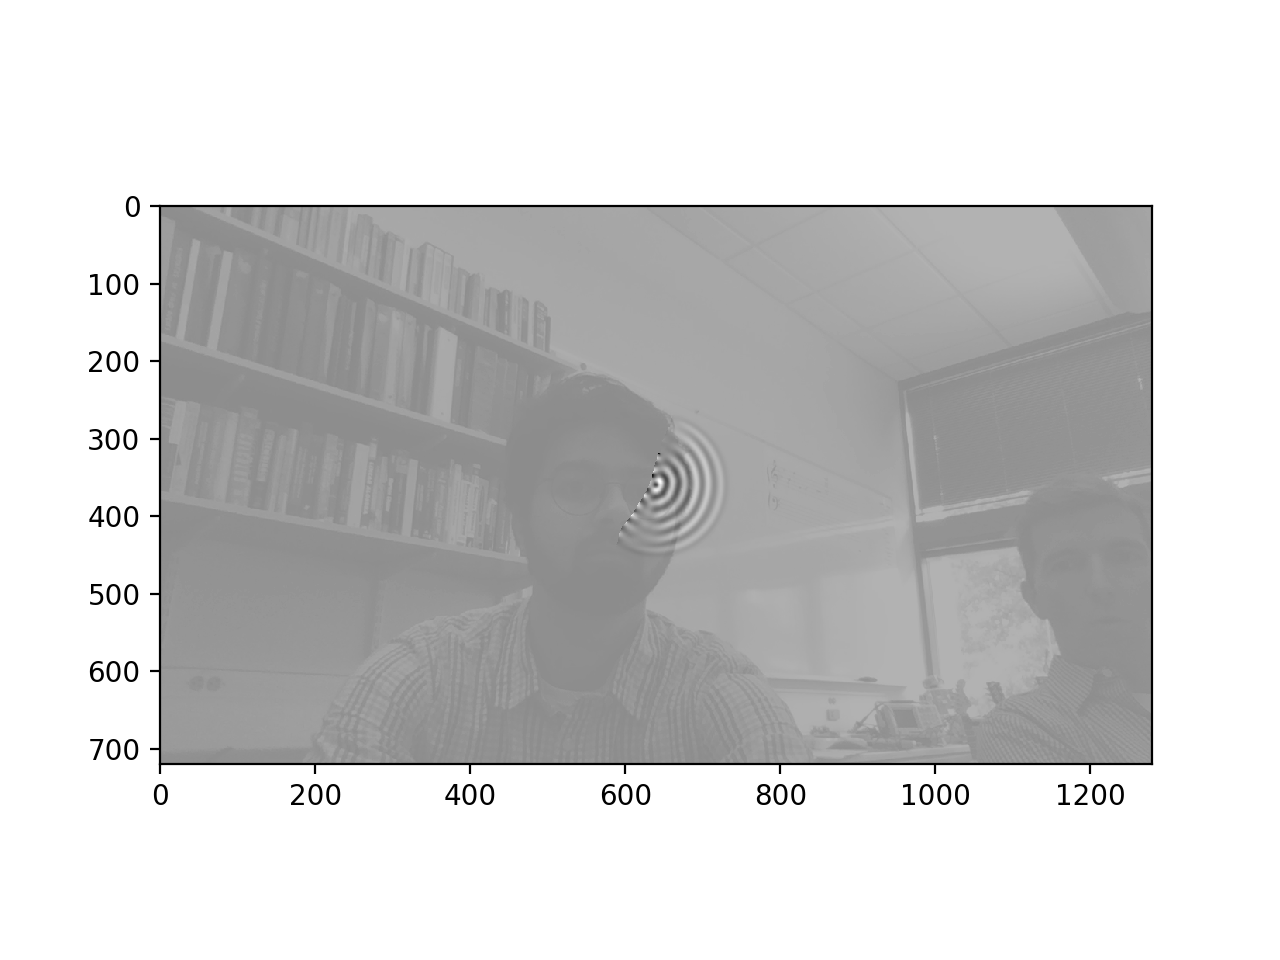

In [6]:
# Create VideoCapture object
cap = cv2.VideoCapture(0)

# Array sizes (resolution dependent)
retval = cap.get(3)
columns = retval
retval = cap.get(4)
rows = retval

# Set frame resolution
if dflag == "c" and columns > 1000:
    print("Default frame resolution ", np.int(columns), "x", np.int(rows))
    if input("Do you want to reduce resolution to increase speed? (y/n): ") == "y":
        print("")
        print("Setting new resolution to 640 x 480")
        print("")
        columns = 640
        rows = 480

cap.set(3, columns)
cap.set(4, rows)

# Create FDTD object
fs = FdtdVar(rows, columns)

tc = 0

if dflag == "c":
    bflag = input("Enter 'c' for a closed domain or 'o' for an open domain: ")
    print("")
    if bflag != "c" and bflag != "o":
        sys.exit("Error: enter 'c' for closed domain or 'o' for open domain")
else:
    bflag = "c"

# Wait to start wave propagation
print("Click on the camera window and press 's' to start wave propagation...")
print("")
while True:
    # Reset domain
    # fs.mvx.fill(0)
    # fs.mvy.fill(0)
    fs.update_domain()

    # Capture frame
    retval, frame = cap.read()

    # Convert to grayscale
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 256.0

    # Create rigid material
    imgtemp = np.pad(img, ((0, 0), (0, 1)), "constant", constant_values=1.0)
    idx = imgtemp < 0.4
    fs.mvx[idx] = 1
    imgtemp = np.pad(img, ((0, 1), (0, 0)), "constant", constant_values=1.0)
    idx = imgtemp < 0.4
    fs.mvy[idx] = 1

    # Display image
    cv2.imshow("frame", img)
    if cv2.waitKey(1) & 0xFF == ord("s"):
        break

print("Press 'q' to quit (when the camera window is topmost)...")
print("")

while True:
    # Capture frame
    retval, frame = cap.read()

    # Convert to grayscale
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)/256.0

    # Update image with FDTD solution
    fs.fdtd_update()
    fs.source(tc)
    if bflag == "o":
        fs.boundary()
    imgdisp = img + fs.pr

    # Display image
    cv2.imshow("frame", imgdisp)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

    tc = tc + 1

# Release the VideoCapture object
cap.release()
cv2.destroyAllWindows()

plt.figure()
plt.imshow(imgdisp, cmap="gray")
plt.show()